In [1]:
import msprime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import tsinfer
import tsdate
from tqdm import tqdm
from torch_geometric.utils import from_networkx
import networkx as nx
%matplotlib inline

In [2]:
cd revisions/

/home/ubuntu/graphseq-inference-analysis/mm-selection-classification/revisions


In [11]:
0

0

In [3]:
label_lookup = {
    "kingman_selection_none" : 0,
    "kingman_selection_weak" : 1,
    "kingman_selection_medium" : 2,
    "kingman_selection_strong" : 3,
    
    "beta_selection_none" : 4,
    "beta_selection_weak" : 5,
    "beta_selection_medium" : 6,
    "beta_selection_strong" : 7,    
}

In [5]:
def simulate_tree_sequence(L, model, seed, sample_size = 10, r = 1e-8, Ne = 100_000, num_replicates=1):
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    ts = msprime.sim_ancestry(
        samples=sample_size,recombination_rate=r, sequence_length=L,
        demography=demography,
        ploidy=1,
        model=model,
        random_seed=seed, num_replicates=num_replicates)
    return list(ts)

def sample_selection_coefficient():
    selection_type = np.random.choice(["strong", "medium", "weak", "none"])
    selection_coefficient = {"strong":[1, 0.1], "medium":[0.1, 0.01], "weak":[0.01, 0.001], "none": None}
    selection_coefficient_range = selection_coefficient[selection_type]
    if selection_type != "none":
        s = np.round(np.random.uniform(selection_coefficient_range[0], selection_coefficient_range[1]), 3)
        return s, selection_type
    else: return 0, selection_type

    
def get_kingman_model(s, L, Ne = 10_000):
    if s != 0:
        model_kingman = [msprime.SweepGenicSelection(position=(L/2),
                                                     start_frequency=(1/Ne),
                                                     end_frequency=0.99,s=s,dt=(1/(40*Ne))),
                         msprime.StandardCoalescent()]
    else: model_kingman = [msprime.StandardCoalescent()]
    return model_kingman


def get_beta_model(alpha, Ne = 1_000_000):
    model_beta = [msprime.BetaCoalescent(alpha=alpha)]
    return model_beta


def get_mid_trees(ts):
    for i, tree in enumerate(ts.trees()):
        if tree.interval.left >= (ts.sequence_length/2):
            break
    first_tree = i-249
    last_tree = i + 250
    trees = []
    for j, tree in enumerate(ts.aslist()):
        if j >= first_tree and j <= last_tree:
            trees.append(tree)
    return trees

def tree_to_data_objects(tree, norm_factor, num_embedding=60):
    max_num_nodes = 2 * 10 - 1 
    data = from_networkx(nx.Graph(tree.as_dict_of_dicts()))
    data.edge_weight = data.branch_length; data.branch_length = None
    data.edge_weight = torch.log(data.edge_weight / norm_factor)
    num_nodes = data.num_nodes
    data.x = torch.eye(max_num_nodes,num_embedding)
    data.x[num_nodes:] = torch.zeros(num_embedding)
    data.num_nodes = max_num_nodes
    return data

In [160]:
def reinferts(ts, mutation_rate=4e-8, recombination_rate=1e-8):
    ts = msprime.mutate(ts, rate=mutation_rate)
    while ts.num_mutations < 1:
        ts = msprime.mutate(ts, rate=mutation_rate)
        print(ts.num_mutations)
    sample_data = tsinfer.SampleData.from_tree_sequence(ts, num_flush_threads=4, use_sites_time=False, use_individuals_time=False)
    ts = tsinfer.infer(sample_data, post_process="simplify", recombination_rate=recombination_rate).simplify(keep_unary=False)
    ts = tsdate.date(ts, Ne=100_000, mutation_rate=mutation_rate)
    return ts

In [7]:
np.random.seed(0x1337)
directory = "./classification-dataset/"

min_num_trees = 2000
for nth_scenario in tqdm(range(40_000)):

    if nth_scenario % 2 == 0:
    
        L = 100_000
        s, selection_type = sample_selection_coefficient()

        model_kingman = get_kingman_model(s, L,  Ne=10_000)
        tree_sequences = simulate_tree_sequence(L, model_kingman, 1+nth_scenario*10, Ne=10_000)
        num_ts_above_1999 = np.sum([1 if ts.num_trees >= min_num_trees else 0 for ts in tree_sequences])

        while num_ts_above_1999 < 1:
            L = L*2
            model_kingman = get_kingman_model(s, L,  Ne=10_000)
            tree_sequences = simulate_tree_sequence(L, model_kingman, 1+nth_scenario*10, Ne=10_000)
            num_ts_above_1999 = np.sum([1 if ts.num_trees >= min_num_trees else 0 for ts in tree_sequences])

        c = 0
        for j, ts in enumerate(tree_sequences):
            y_dict = {"model": ("kingman", None), "sequence_length":L, "selection_coefficient":s, "selection_type":selection_type}
            trees = get_mid_trees(ts)
            data_objects = [tree_to_data_objects(tree, norm_factor=10_000, num_embedding=60) for tree in trees]
            torch.save((data_objects, y_dict),  open(str(directory) + "kingman_" + str(nth_scenario) + "_" + str(j) + ".pth", "wb"))
            c += 1
            
                
            #break 
        #break
    else:
        
        L = 100_000
        alpha = np.round(np.random.uniform(1.01, 1.99), 2)
        model_beta = get_beta_model(alpha, Ne=1_000_000)
        tree_sequences = simulate_tree_sequence(L, model_beta, 1+nth_scenario*10, Ne=1_000_000)
        num_ts_above_1999 = np.sum([1 if ts.num_trees >= min_num_trees else 0 for ts in tree_sequences])

        while num_ts_above_1999 < 1:
            L = L*2
            #print(L, num_ts_above_1999)
            model_beta = get_beta_model(alpha, Ne=1_000_000)
            tree_sequences = simulate_tree_sequence(L, model_beta, 1+nth_scenario*10, Ne=1_000_000)
            num_ts_above_1999 = np.sum([1 if ts.num_trees >= min_num_trees else 0 for ts in tree_sequences])

        c = 0
        for j, ts in enumerate(tree_sequences):
            y_dict = {"model": ("beta", alpha), "sequence_length":L, "selection_coefficient":0, "selection_type":None}
            trees = get_mid_trees(ts)
            data_objects = [tree_to_data_objects(tree, norm_factor=1_000_000, num_embedding=60) for tree in trees]
            torch.save((data_objects, y_dict),  open(str(directory) + "beta_" + str(nth_scenario) + "_" + str(j) + ".pth", "wb"))
            c += 1

            #break 
        #break
    #print(nth_scenario, y_dict)

 48%|███████████████████████████████████████████▎                                               | 19058/40000 [6:37:26<9:08:19,  1.57s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 74%|██████████████████████████████████████████████████████████████████▌                       | 29573/40000 [10:31:05<3:14:00,  1.12s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [146]:
from scipy.special import beta
def calculate_kingman_coal_ne_estimate(theta, sample_size, L, mu_real):
    mu_estimated = theta / ((2*np.sum(1/np.array(range(1, sample_size)))) * L)
    Ne = (mu_estimated / mu_real)
    return Ne

def calculate_beta_coal_ne_estimate(theta, sample_size, L, alpha, mu_real):
    mu_estimated = theta / ((2*np.sum(1/np.array(range(1, sample_size)))) * L)
    m = 1 + (1/((2**(alpha-1))*(alpha-1)))
    scale = (m**alpha)/(alpha * beta(2-alpha,alpha))
    Ne = (((mu_estimated/mu_real)/scale)**(1/(alpha-1)))
    return Ne

In [150]:
mutation_rate = 1e-8
ts = msprime.mutate(ts, rate=mutation_rate)
calculate_kingman_coal_ne_estimate(theta=ts.num_mutations,
                                   sample_size=ts.num_samples, L=ts.sequence_length, mu_real=mutation_rate)

8420.141324168888

In [138]:
mutation_rate = 1e-8
ts = msprime.mutate(ts, rate=mutation_rate)
calculate_beta_coal_ne_estimate(theta=ts.num_mutations,
                                   sample_size=ts.num_samples, L=ts.sequence_length, mu_real=mutation_rate, alpha=1.86)

1034589.1429456391

In [161]:
reinfts = reinferts(ts, mutation_rate=2e-8)

In [ ]:
for tree in reinfts.trees():
    tree

In [178]:
data_objects = [tree_to_data_objects(tree, norm_factor=10_000, num_embedding=60) for tree in trees]

AttributeError: 'GlobalStorage' object has no attribute 'branch_length'

In [152]:
data_objects = [tree_to_data_objects(tree, norm_factor=10_000, num_embedding=60) for tree in trees]

In [140]:
data_objects = [tree_to_data_objects(tree, norm_factor=1_000_000, num_embedding=60) for tree in trees]

In [155]:
edge_weights = [d.edge_weight.sum().item() for d in data_objects]

<Axes: >

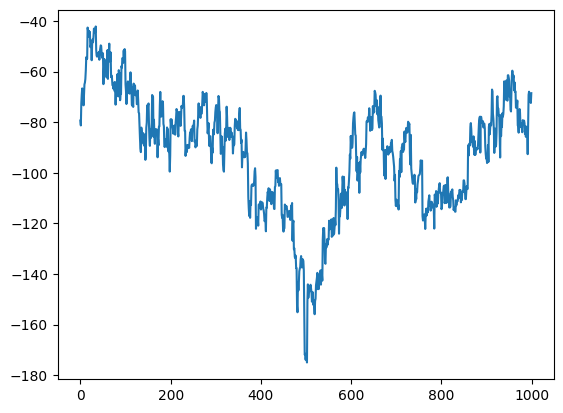

In [159]:
sns.lineplot(edge_weights)

In [82]:
#torch.exp(data_object.edge_weight).numpy().tolist()

In [20]:
np.random.seed(0x999999)
directory = "./inf_validation_classification_dataset/"


for nth_scenario in range(10_000):

    if nth_scenario % 2 == 0:
    
    
        L = 1_000_000
        s, selection_type = sample_selection_coefficient()

        model_kingman = get_kingman_model(s, L)
        tree_sequences = simulate_tree_sequence(L, model_kingman, 1+nth_scenario*10, num_replicates=1)
        tree_sequences = [reinferts(ts) for ts in tree_sequences]
        num_ts_above_1999 = np.sum([1 if ts.num_trees >= 1000 else 0 for ts in tree_sequences])

        while num_ts_above_1999 < 1:
            L = L*2
            #print(L)
            model_kingman = get_kingman_model(s, L)
            tree_sequences = simulate_tree_sequence(L, model_kingman, 1+nth_scenario*10, num_replicates=1)
            tree_sequences = [reinferts(ts) for ts in tree_sequences]
            
            num_ts_above_1999 = np.sum([1 if ts.num_trees >= 1000 else 0 for ts in tree_sequences])



        
        c = 0
        for j, ts in enumerate(tree_sequences):

            if ts.num_trees >= 1000 and c < 1:
                y_dict = {"model": ("kingman", None), "sequence_length":L, "selection_coefficient":s, "selection_type":selection_type}
                torch.save((ts, y_dict),  open(str(directory) + "kingman_" + str(nth_scenario) + "_" + str(j) + ".pth", "wb"))
                c += 1
                
    else:
        
        L = 1_000_000
        
        alpha = np.round(np.random.uniform(1.01, 1.99), 2)
        model_beta = get_beta_model(alpha)
        
        tree_sequences = simulate_tree_sequence(L, model_beta, 1+nth_scenario*10, num_replicates=1)
        tree_sequences = [reinferts(ts) for ts in tree_sequences]

        num_ts_above_1999 = np.sum([1 if ts.num_trees >= 1000 else 0 for ts in tree_sequences])

        while num_ts_above_1999 < 1:
            L = L*2
            #print(L, num_ts_above_1999)
            model_beta = get_beta_model(alpha)
            tree_sequences = simulate_tree_sequence(L, model_beta, 1+nth_scenario*10, num_replicates=1)
            tree_sequences = [reinferts(ts) for ts in tree_sequences]
            
            num_ts_above_1999 = np.sum([1 if ts.num_trees >= 1000 else 0 for ts in tree_sequences])


        c = 0
        for j, ts in enumerate(tree_sequences):

            if ts.num_trees >= 1000 and c < 1:
                y_dict = {"model": ("beta", alpha), "sequence_length":L, "selection_coefficient":0, "selection_type":None}
                torch.save((ts, y_dict),  open(str(directory) + "beta_" + str(nth_scenario) + "_" + str(j) + ".pth", "wb"))
                c += 1

    print(nth_scenario, y_dict)

0 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.751, 'selection_type': 'strong'}
1 {'model': ('beta', 1.84), 'sequence_length': 16000000, 'selection_coefficient': 0, 'selection_type': None}
2 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0.006, 'selection_type': 'weak'}
3 {'model': ('beta', 1.07), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
4 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.036, 'selection_type': 'medium'}
5 {'model': ('beta', 1.38), 'sequence_length': 512000000, 'selection_coefficient': 0, 'selection_type': None}
6 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.053, 'selection_type': 'medium'}
7 {'model': ('beta', 1.27), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
8 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0

KeyboardInterrupt: 

In [23]:
#mkdir inferred_undated_classification_dataset

In [22]:
def reinferts(ts, mutation_rate=4e-8, recombination_rate=1e-8):
    ts = msprime.mutate(ts, rate=mutation_rate)
    while ts.num_mutations < 1:
        ts = msprime.mutate(ts, rate=mutation_rate)
        print(ts.num_mutations)
    sample_data = tsinfer.SampleData.from_tree_sequence(ts, num_flush_threads=4, use_sites_time=False, use_individuals_time=False)
    ts = tsinfer.infer(sample_data, post_process="simplify", recombination_rate=recombination_rate).simplify(keep_unary=False)
    #ts = tsdate.date(ts, Ne=100_000, mutation_rate=mutation_rate)
    return ts

In [ ]:
np.random.seed(0x999999)
directory = "./inferred_undated_classification_dataset/"


for nth_scenario in range(0, 10_000):

    if nth_scenario % 2 == 0:
    
    
        L = 1_000_000
        s, selection_type = sample_selection_coefficient()

        model_kingman = get_kingman_model(s, L)
        tree_sequences = simulate_tree_sequence(L, model_kingman, 1+nth_scenario*10, num_replicates=1)
        tree_sequences = [reinferts(ts) for ts in tree_sequences]
        num_ts_above_1999 = np.sum([1 if ts.num_trees >= 1000 else 0 for ts in tree_sequences])

        while num_ts_above_1999 < 1:
            L = L*2
            #print(L)
            model_kingman = get_kingman_model(s, L)
            tree_sequences = simulate_tree_sequence(L, model_kingman, 1+nth_scenario*10, num_replicates=1)
            tree_sequences = [reinferts(ts) for ts in tree_sequences]
            
            num_ts_above_1999 = np.sum([1 if ts.num_trees >= 1000 else 0 for ts in tree_sequences])



        
        c = 0
        for j, ts in enumerate(tree_sequences):

            if ts.num_trees >= 1000 and c < 1:
                y_dict = {"model": ("kingman", None), "sequence_length":L, "selection_coefficient":s, "selection_type":selection_type}
                torch.save((ts, y_dict),  open(str(directory) + "kingman_" + str(nth_scenario) + "_" + str(j) + ".pth", "wb"))
                c += 1
                
    else:
        
        L = 1_000_000
        
        alpha = np.round(np.random.uniform(1.01, 1.99), 2)
        model_beta = get_beta_model(alpha)
        
        tree_sequences = simulate_tree_sequence(L, model_beta, 1+nth_scenario*10, num_replicates=1)
        tree_sequences = [reinferts(ts) for ts in tree_sequences]

        num_ts_above_1999 = np.sum([1 if ts.num_trees >= 1000 else 0 for ts in tree_sequences])

        while num_ts_above_1999 < 1:
            L = L*2
            #print(L, num_ts_above_1999)
            model_beta = get_beta_model(alpha)
            tree_sequences = simulate_tree_sequence(L, model_beta, 1+nth_scenario*10, num_replicates=1)
            tree_sequences = [reinferts(ts) for ts in tree_sequences]
            
            num_ts_above_1999 = np.sum([1 if ts.num_trees >= 1000 else 0 for ts in tree_sequences])


        c = 0
        for j, ts in enumerate(tree_sequences):

            if ts.num_trees >= 1000 and c < 1:
                y_dict = {"model": ("beta", alpha), "sequence_length":L, "selection_coefficient":0, "selection_type":None}
                torch.save((ts, y_dict),  open(str(directory) + "beta_" + str(nth_scenario) + "_" + str(j) + ".pth", "wb"))
                c += 1

    print(nth_scenario, y_dict)

0 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.751, 'selection_type': 'strong'}
1 {'model': ('beta', 1.84), 'sequence_length': 16000000, 'selection_coefficient': 0, 'selection_type': None}
2 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.006, 'selection_type': 'weak'}
3 {'model': ('beta', 1.07), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
4 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.036, 'selection_type': 'medium'}
5 {'model': ('beta', 1.38), 'sequence_length': 512000000, 'selection_coefficient': 0, 'selection_type': None}
6 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.053, 'selection_type': 'medium'}
7 {'model': ('beta', 1.27), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
8 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0

42 {'model': ('kingman', None), 'sequence_length': 8000000, 'selection_coefficient': 0.611, 'selection_type': 'strong'}
43 {'model': ('beta', 1.03), 'sequence_length': 1024000000, 'selection_coefficient': 0, 'selection_type': None}
44 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.347, 'selection_type': 'strong'}
45 {'model': ('beta', 1.21), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
46 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.084, 'selection_type': 'medium'}
47 {'model': ('beta', 1.02), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
48 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.066, 'selection_type': 'medium'}
49 {'model': ('beta', 1.25), 'sequence_length': 8192000000, 'selection_coefficient': 0, 'selection_type': None}
50 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_c

85 {'model': ('beta', 1.06), 'sequence_length': 4096000000, 'selection_coefficient': 0, 'selection_type': None}
86 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0.006, 'selection_type': 'weak'}
87 {'model': ('beta', 1.9), 'sequence_length': 16000000, 'selection_coefficient': 0, 'selection_type': None}
88 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
89 {'model': ('beta', 1.85), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
90 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.082, 'selection_type': 'medium'}
91 {'model': ('beta', 1.52), 'sequence_length': 256000000, 'selection_coefficient': 0, 'selection_type': None}
92 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0.001, 'selection_type': 'weak'}
93 {'model': ('beta', 1.14), 'sequence_length': 2048000000, 'selection_coefficient': 0, 

112 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.026, 'selection_type': 'medium'}
113 {'model': ('beta', 1.33), 'sequence_length': 1024000000, 'selection_coefficient': 0, 'selection_type': None}
114 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.349, 'selection_type': 'strong'}
115 {'model': ('beta', 1.98), 'sequence_length': 64000000, 'selection_coefficient': 0, 'selection_type': None}
116 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
117 {'model': ('beta', 1.45), 'sequence_length': 256000000, 'selection_coefficient': 0, 'selection_type': None}
118 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.527, 'selection_type': 'strong'}
119 {'model': ('beta', 1.96), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
120 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coe

123 {'model': ('beta', 1.13), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
124 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
125 {'model': ('beta', 1.1), 'sequence_length': 65536000000, 'selection_coefficient': 0, 'selection_type': None}
126 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0.008, 'selection_type': 'weak'}
127 {'model': ('beta', 1.84), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
128 {'model': ('kingman', None), 'sequence_length': 8000000, 'selection_coefficient': 0.664, 'selection_type': 'strong'}
129 {'model': ('beta', 1.9), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
130 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.075, 'selection_type': 'medium'}
131 {'model': ('beta', 1.65), 'sequence_length': 128000000, 'selection_coeffi

144 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.085, 'selection_type': 'medium'}


145 {'model': ('beta', 1.17), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}


146 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0.005, 'selection_type': 'weak'}
0
0
0
1


147 {'model': ('beta', 1.14), 'sequence_length': 1024000000, 'selection_coefficient': 0, 'selection_type': None}
148 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.013, 'selection_type': 'medium'}
149 {'model': ('beta', 1.17), 'sequence_length': 4096000000, 'selection_coefficient': 0, 'selection_type': None}
150 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.278, 'selection_type': 'strong'}
151 {'model': ('beta', 1.82), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
152 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.009, 'selection_type': 'weak'}
153 {'model': ('beta', 1.16), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
154 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
155 {'model': ('beta', 1.18), 'sequence_length': 2048000000, 'selection_co

172 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
173 {'model': ('beta', 1.04), 'sequence_length': 4096000000, 'selection_coefficient': 0, 'selection_type': None}
174 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
175 {'model': ('beta', 1.77), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
176 {'model': ('kingman', None), 'sequence_length': 8000000, 'selection_coefficient': 0.587, 'selection_type': 'strong'}
177 {'model': ('beta', 1.73), 'sequence_length': 64000000, 'selection_coefficient': 0, 'selection_type': None}
178 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.016, 'selection_type': 'medium'}
179 {'model': ('beta', 1.6), 'sequence_length': 128000000, 'selection_coefficient': 0, 'selection_type': None}
180 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficien

205 {'model': ('beta', 1.66), 'sequence_length': 64000000, 'selection_coefficient': 0, 'selection_type': None}
206 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.514, 'selection_type': 'strong'}
207 {'model': ('beta', 1.32), 'sequence_length': 1024000000, 'selection_coefficient': 0, 'selection_type': None}
208 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
209 {'model': ('beta', 1.93), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
210 {'model': ('kingman', None), 'sequence_length': 8000000, 'selection_coefficient': 0.597, 'selection_type': 'strong'}
211 {'model': ('beta', 1.51), 'sequence_length': 128000000, 'selection_coefficient': 0, 'selection_type': None}
212 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.391, 'selection_type': 'strong'}
213 {'model': ('beta', 1.73), 'sequence_length': 32000000, 'selection_coeff

256 {'model': ('kingman', None), 'sequence_length': 8000000, 'selection_coefficient': 0.401, 'selection_type': 'strong'}


257 {'model': ('beta', 1.19), 'sequence_length': 1024000000, 'selection_coefficient': 0, 'selection_type': None}
258 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.034, 'selection_type': 'medium'}
259 {'model': ('beta', 1.25), 'sequence_length': 4096000000, 'selection_coefficient': 0, 'selection_type': None}
260 {'model': ('kingman', None), 'sequence_length': 4000000, 'selection_coefficient': 0.087, 'selection_type': 'medium'}
261 {'model': ('beta', 1.59), 'sequence_length': 128000000, 'selection_coefficient': 0, 'selection_type': None}
262 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
263 {'model': ('beta', 1.47), 'sequence_length': 256000000, 'selection_coefficient': 0, 'selection_type': None}
264 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0.006, 'selection_type': 'weak'}
265 {'model': ('beta', 1.33), 'sequence_length': 512000000, 'selection_coe

280 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0, 'selection_type': 'none'}
281 {'model': ('beta', 1.08), 'sequence_length': 4096000000, 'selection_coefficient': 0, 'selection_type': None}
282 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.007, 'selection_type': 'weak'}


283 {'model': ('beta', 1.3), 'sequence_length': 2048000000, 'selection_coefficient': 0, 'selection_type': None}
284 {'model': ('kingman', None), 'sequence_length': 8000000, 'selection_coefficient': 0.914, 'selection_type': 'strong'}
285 {'model': ('beta', 1.64), 'sequence_length': 128000000, 'selection_coefficient': 0, 'selection_type': None}
286 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.063, 'selection_type': 'medium'}
287 {'model': ('beta', 1.39), 'sequence_length': 512000000, 'selection_coefficient': 0, 'selection_type': None}
288 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0.004, 'selection_type': 'weak'}
289 {'model': ('beta', 1.06), 'sequence_length': 4096000000, 'selection_coefficient': 0, 'selection_type': None}
290 {'model': ('kingman', None), 'sequence_length': 2000000, 'selection_coefficient': 0.007, 'selection_type': 'weak'}
291 {'model': ('beta', 1.99), 'sequence_length': 128000000, 'selection_

303 {'model': ('beta', 1.6), 'sequence_length': 64000000, 'selection_coefficient': 0, 'selection_type': None}
304 {'model': ('kingman', None), 'sequence_length': 16000000, 'selection_coefficient': 0.811, 'selection_type': 'strong'}
305 {'model': ('beta', 1.89), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
306 {'model': ('kingman', None), 'sequence_length': 1000000, 'selection_coefficient': 0.01, 'selection_type': 'weak'}
307 {'model': ('beta', 1.94), 'sequence_length': 32000000, 'selection_coefficient': 0, 'selection_type': None}
